## Import and Preprocessing

In [49]:
!pip install nltk
! pip install nltk
! pip install yellowbrick
! pip install umap-learn
! pip install plotly
! pip install transformers
! pip install pyLDAvis
! pip install pyyaml==5.4.1
! pip install tensorflow tensorflow_hub
seed=42

  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [50]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from shutil import copyfile
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.metrics import (rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score, silhouette_score)
import tensorflow as tf
import tensorflow_hub as hub
from bs4 import BeautifulSoup

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [51]:
from google.colab import drive
import shutil

drive.mount('/content/gdrive')

#source_path = '/content/gdrive/My Drive/Colab Notebooks/yelp_dataset/pre_processed.csv'
#source_path = '/content/gdrive/My Drive/Colab Notebooks/dataset/trainStackOverflow.csv'
source_path = '/content/gdrive/MyDrive/dataset_text_mining/pre_processed.csv'
#train_source_path = '/content/gdrive/MyDrive/StackOverflow dataset/train.csv'
#valid_source_path = '/content/gdrive/MyDrive/StackOverflow dataset/valid.csv'

destination_path = '/content/dataset_yelp.csv'
#train_destination_path = '/content/trainStackOverflow.csv'
#valid_destination_path = '/content/validStackOverflow.csv'

#shutil.copyfile(train_source_path, train_destination_path)
shutil.copyfile(source_path, destination_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/dataset_yelp.csv'

In [52]:
data = pd.read_csv('dataset_yelp.csv')
data.shape

(92376, 56)

In [53]:
data.head()

,Unnamed: 0,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,...,Mexican,Beauty & Spas,Pubs,Cajun/Creole,Event Planning & Services,Venues & Event Spaces,Bakeries,Hotels,Specialty Food,Main_category
0,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,...,0,0,0,0,0,0,0,0,0,Sandwiches
1,10,rGQRf8UafX7OTlMNN19I8A,1WHRWwQmZOZDAhp2Qyny4g,uMvVYRgGNXf5boolA9HXTw,5.0,2,0,0,My experience with Shalimar was nothing but wo...,2015-06-21 14:48:06,...,0,0,0,0,0,0,0,0,0,Shopping
2,12,XW_LfMv0fV21l9c6xQd_lw,9OAtfnWag-ajVxRbUTGIyg,lj-E32x9_FA7GmUrBGBEWg,4.0,0,0,0,Love going here for happy hour or dinner! Gre...,2014-06-27 22:44:01,...,0,0,0,0,0,0,0,0,0,Bars
3,13,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,...,0,0,0,0,0,0,0,0,0,Pizza
4,15,OAhBYw8IQ6wlfw1owXWRWw,1C2lxzUo1Hyye4RFIXly3g,BVndHaLihEYbr76Z0CMEGw,5.0,0,0,0,"Great place for breakfast! I had the waffle, w...",2014-10-11 16:22:06,...,0,0,0,0,0,0,0,0,0,Sandwiches


In [54]:
data.drop(['Unnamed: 0', 'stars_y'], axis = 1,inplace=True)
data.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,Mexican,Beauty & Spas,Pubs,Cajun/Creole,Event Planning & Services,Venues & Event Spaces,Bakeries,Hotels,Specialty Food,Main_category
0,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,0,0,0,0,0,0,0,0,0,Sandwiches
1,rGQRf8UafX7OTlMNN19I8A,1WHRWwQmZOZDAhp2Qyny4g,uMvVYRgGNXf5boolA9HXTw,5.0,2,0,0,My experience with Shalimar was nothing but wo...,2015-06-21 14:48:06,Shalimar Fine Jewelers,...,0,0,0,0,0,0,0,0,0,Shopping
2,XW_LfMv0fV21l9c6xQd_lw,9OAtfnWag-ajVxRbUTGIyg,lj-E32x9_FA7GmUrBGBEWg,4.0,0,0,0,Love going here for happy hour or dinner! Gre...,2014-06-27 22:44:01,Brio Italian Grille,...,0,0,0,0,0,0,0,0,0,Bars
3,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,LaScala's,...,0,0,0,0,0,0,0,0,0,Pizza
4,OAhBYw8IQ6wlfw1owXWRWw,1C2lxzUo1Hyye4RFIXly3g,BVndHaLihEYbr76Z0CMEGw,5.0,0,0,0,"Great place for breakfast! I had the waffle, w...",2014-10-11 16:22:06,Mamas Kitchen,...,0,0,0,0,0,0,0,0,0,Sandwiches


In [55]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english') + ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd"]
    lower_text = text.lower()                                              # Converting all words into lower case.
    filtered_text = re.sub(sub_pattern,' ',lower_text).lstrip().rstrip()   # Replacing all characters except those in the pattern into spaces.
    filtered_text = word_tokenize(filtered_text)                            # tokenizethe whole book into words in a list.
    filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_text if word not in stop_words]
    #return filtered_text
    return ' '.join(filtered_text)

def normalize_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(filtered_tokens)

In [56]:
dataset = pd.DataFrame()
dataset['text'] = data['text']
dataset['cat'] = data['Main_category']
dataset.head()

,text,cat
0,Cute interior and owner (?) gave us tour of up...,Sandwiches
1,My experience with Shalimar was nothing but wo...,Shopping
2,Love going here for happy hour or dinner! Gre...,Bars
3,Good food--loved the gnocchi with marinara\nth...,Pizza
4,"Great place for breakfast! I had the waffle, w...",Sandwiches


In [57]:
dataset.shape

(92376, 2)

In [58]:
sample_size = 10000
dataset_sampled = dataset.sample(n=sample_size, random_state=42)
print(dataset_sampled.shape)

(10000, 2)


In [59]:
dataset_sampled['cleaned_text'] = dataset_sampled['text'].apply(lambda x: clean_text(x))
dataset_sampled['normalized_text'] = dataset_sampled['text'].apply(lambda x: normalize_text(x))

In [60]:
from collections import Counter

# Calcola la frequenza delle parole
all_words = ' '.join(dataset_sampled['cleaned_text']).split()
word_freq = Counter(all_words)

# Filtra le parole che appaiono più di una certa soglia (es. 1000 volte)
frequent_words = {word for word, count in word_freq.items() if count > 500}

def remove_frequent_words(text):
    return ' '.join([word for word in text.split() if word not in frequent_words])

dataset_sampled['cleaned_text'] = dataset_sampled['cleaned_text'].apply(remove_frequent_words)

In [61]:
from nltk.corpus import wordnet

# Esempio con WordNet (per inglese)
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def replace_synonyms(text):
    words = text.split()
    new_words = []
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            new_words.append(list(synonyms)[0])  # Sostituisci con uno dei sinonimi
        else:
            new_words.append(word)
    return ' '.join(new_words)

dataset_sampled['cleaned_text'] = dataset_sampled['cleaned_text'].apply(replace_synonyms)

In [62]:
print(dataset_sampled[['text', 'cleaned_text', 'normalized_text']].head(3))

                                                    text  \
25355  Not a bad place. Its kind of pricey-- I got a ...   
57045  1. Surprised this is attached to a Hilton\n2. ...   
70365  We went there for a work conference and stayed...   

                                            cleaned_text  \
25355  genial dear gel gunpowder replenish gel polish...   
57045  surprise bind hilton outer_space salty wine na...   
70365  group_discussion remain Tuscan predominate dis...   

                                         normalized_text  
25355  bad place kind pricey got gel powder refill ge...  
57045  surprised attached hilton space small food see...  
70365  went work conference stayed tuscan towers nice...  


## Bag of Word

In [63]:
'''
from sklearn.feature_extraction.text import CountVectorizer
BOW = CountVectorizer()
BOW_transformation = BOW.fit_transform(filtered_dataset['cleaned_text'])
'''

"\nfrom sklearn.feature_extraction.text import CountVectorizer\nBOW = CountVectorizer()\nBOW_transformation = BOW.fit_transform(filtered_dataset['cleaned_text'])\n"

In [64]:
#BOW_transformation.shape

## TF-IDF

In [65]:

from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_ngram(n_gram,X_train=dataset_sampled['cleaned_text']):
    vectorizer = TfidfVectorizer(ngram_range=(n_gram,n_gram))
    x_train_vec = vectorizer.fit_transform(X_train)
    return x_train_vec


In [66]:

tfidf_1g_transformation= tfidf_ngram(1,X_train=dataset_sampled['cleaned_text'])
tfidf_2g_transformation= tfidf_ngram(2,X_train=dataset_sampled['cleaned_text'])


In [67]:
tfidf_1g_transformation.shape, tfidf_2g_transformation.shape

((10000, 14416), (10000, 211837))

## Doc2Vec

In [37]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

tokenized_doc = []
for d in dataset_sampled['cleaned_text']:
    tokenized_doc.append(word_tokenize(d.lower()))


tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
tagged_data[0]

TaggedDocument(words=['genial', 'dear', 'gel', 'gunpowder', 'replenish', 'gel', 'polish', 'nab', 'supercede', 'in_concert', 'pedicure', 'thus_far', 'await', 'essence', 'city', 'wasnt', 'surprise', 'outside', 'though', 'early', 'fitting', 'massage', 'nab', 'ironic', 'somewhat', 'pleased'], tags=[0])

In [68]:
model = Doc2Vec(tagged_data, vector_size=75, window=2, min_count=1, workers=4, epochs = 100)

In [69]:
def get_doc2vec_vector(df):
    doc2vec_vectors=[]
    for sentence in dataset_sampled['cleaned_text']:
        doc2vec_vectors.append(model.infer_vector(word_tokenize(sentence.lower())))
    return doc2vec_vectors
doc2vec_vectors=get_doc2vec_vector(dataset_sampled['cleaned_text'])
len(doc2vec_vectors)

10000

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering

In [71]:
df = dataset_sampled.copy()
X, y = doc2vec_vectors, df['cat']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, recall_score

In [73]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred)

print("Accuracy: %s" % accuracy_score(y_test,y_pred))


# EXERCISE: fit and predict!
clf = SVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n")
print("SVM")
print("Accuracy: %s" % accuracy_score(y_test,y_pred))


# EXERCISE: fit and predict!
clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n")
print("RF")
print("Accuracy: %s" % accuracy_score(y_test,y_pred))


['Event Planning & Services' 'Cafes' 'Event Planning & Services' ...
 'Event Planning & Services' 'Italian' 'Burgers']
Accuracy: 0.098


SVM
Accuracy: 0.3552


RF
Accuracy: 0.2188


In [44]:
doc2vec_matrix = np.array(doc2vec_vectors)
doc2vec_matrix.shape

(10000, 75)

Text(0, 0.5, 'Explained variance up to Nth component')

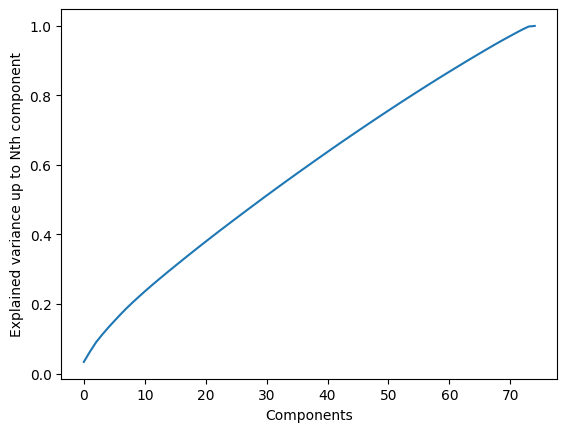

In [46]:
pca = PCA(n_components=75)
pca_doc2vec = pca.fit_transform(doc2vec_matrix)
pca_doc2vec.shape
pca.explained_variance_ratio_.shape
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Explained variance up to Nth component')

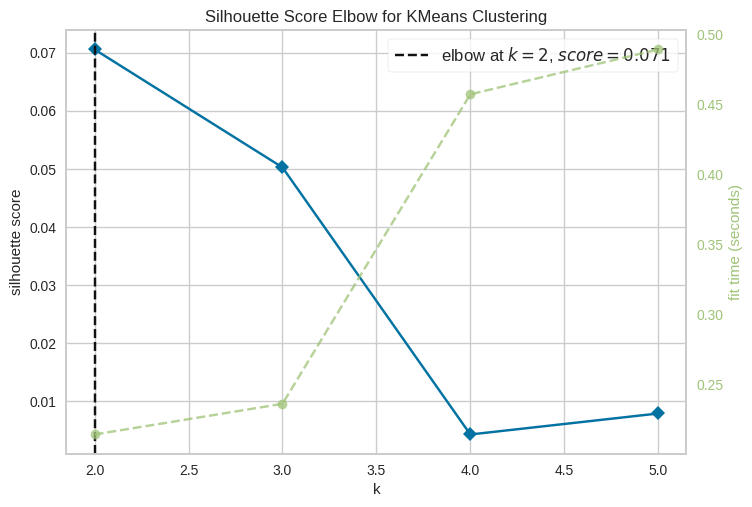

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [75]:
from yellowbrick.cluster import KElbowVisualizer


model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 6), metric='silhouette')


visualizer.fit(doc2vec_vectors)
visualizer.show()


## Bert

In [51]:
!pip install transformers

In [52]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00


In [53]:
# Check the GPU
import torch
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [56]:
# Import Libraries
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AlbertTokenizer, AlbertModel
from keras_preprocessing.sequence import pad_sequences
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create sentence and label lists
sentences = dataset_sampled['normalized_text'].values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

# Initialize the tokenizer
tokenizer = AlbertTokenizer.from_pretrained("albert/albert-base-v1")
# Tokenize the sentences and put them in the list tokenized_texts
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
hidden_states=[]
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
# Conver the ids into a tensor representation
batch_size = 4
input_tensor = torch.tensor(input_ids)
masks_tensor = torch.tensor(attention_masks)
train_data = TensorDataset(input_tensor, masks_tensor)
dataloader = DataLoader(train_data, batch_size=batch_size)
# Initialize the model
if torch.cuda.is_available():
    model = AlbertModel.from_pretrained("albert/albert-base-v1",output_hidden_states = True,).to('cuda')
else:
    model = AlbertModel.from_pretrained("albert/albert-base-v1",output_hidden_states = True,).to('cpu')
model.eval()
outputs = []

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

In [57]:
for input, masks in dataloader:
    torch.cuda.empty_cache() # empty the gpu memory
    # Transfer the batch to gp
    if torch.cuda.is_available():
        input = input.to('cuda')
        masks = masks.to('cuda')
    # Run inference on the batch
    output = model(input, attention_mask=masks)
    # Transfer the output to CPU again and convert to numpy
    #output = output[0].cpu().detach().numpy()
    # Store the output in a list
    outputs.append(output)
# Concatenate all the lists within the list into one list
outputs = [x for y in outputs for x in y]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 658421 has 14.73 GiB memory in use. Of the allocated memory 14.60 GiB is allocated by PyTorch, and 6.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
bert_vectors=np.array(outputs)
bert_vectors=bert_vectors.mean(axis=1)
bert_vectors.shape

In [ ]:
pca = PCA(n_components=)
pca_bert = pca.fit_transform(doc2vec_matrix)
pca_bert.shape
pca.explained_variance_ratio_.shape #is the number of information/data that contribute into explaining the dataset (it finds the correlation between data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Explained variance up to Nth component')

## Glove

In [ ]:
import gensim.downloader as api
def get_vectors_pretrained(df, model):
    embedding_vectors = []
    for partition in df['cleaned_text']:
        sentence = []
        for word in partition.split(' '):
            try:
                sentence.append(model[word])
            except:
                pass
        sentence = np.array(sentence)
        sentence = sentence.mean(axis=0)
        embedding_vectors.append(sentence)
    embedding_vectors = np.array(embedding_vectors)
    return embedding_vectors

In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-300")
glove_vectors=get_vectors_pretrained(filtered_dataset,glove_model)
glove_vectors

[==================================================] 100.0% 376.1/376.1MB downloaded


<ipython-input-24-855fa67b083e>:12: RuntimeWarning: Mean of empty slice.
  sentence = sentence.mean(axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (36269,) + inhomogeneous part.

## FastText

In [ ]:
dt = pd.DataFrame()
dt = filtered_dataset[['cleaned_text', 'tag']]

import gensim.downloader as api
fast_text_model = api.load("fasttext-wiki-news-subwords-300")
fast_text_vectors=get_vectors_pretrained(dt,fast_text_model)
fast_text_vectors.shape

[==================================================] 100.0% 958.5/958.4MB downloaded


<ipython-input-24-855fa67b083e>:12: RuntimeWarning: Mean of empty slice.
  sentence = sentence.mean(axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (36269,) + inhomogeneous part.

## LDA (Latent Dirichlet Allocation)

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import gensim

paragraphs = filtered_dataset['cleaned_text'].to_list()
docs = []

for sen in paragraphs:
    docs.append(list(sen.split()))
print(len(docs))

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.8)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
print(len(corpus[2]))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

5000
47
Number of unique tokens: 1377
Number of documents: 5000


In [ ]:
# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
#print(len(dictionary))
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.9810.


In [ ]:
all_topics = model.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr = gensim.matutils.corpus2csc(all_topics)
lda_to_cluster = all_topics_csr.T.toarray()
lda_to_cluster.shape

(5000, 5)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
## Evaluating coherence of gensim LDA model
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence_score = cm.get_coherence()
print(coherence_score)

-1.9809689253816618


## Embedding dictionary

In [40]:
text_embedding={
    #'BOW':BOW_transformation.toarray(),
    'TF_IDF 1_gram':tfidf_1g_transformation.toarray(),
    'Doc2vec':np.array(doc2vec_vectors),
    #'Glove':glove_vectors,
    #'FastText':fast_text_vectors,
    #'Word2vec':word2vec_vectors,
    #'BERT':X,
    #'LDA':lda_to_cluster,
}

In [ ]:
import pickle
a_file = open("EmbeddingText_edited.pkl", "wb")
pickle.dump(text_embedding, a_file)
a_file.close()
print('Saved')

Saved


## Word Embedding Visualization

In [41]:
import plotly.express as px
from sklearn.decomposition import PCA
pca=PCA(n_components=3,)
embedding=text_embedding.copy()

for key in embedding.keys():
  embedding[key]=pca.fit_transform(embedding[key])
  df=pd.DataFrame({'PCA1':embedding[key][:,0],'PCA2':embedding[key][:,1],'PCA3':embedding[key][:,2],'Target':np.zeros(10000)})
  fig = px.scatter_3d(data_frame =df, x='PCA1', y='PCA2', z ='PCA3', color='Target')
  fig.update_layout(title={'text':f'{key}','x':0.5},height=500,width=700)
  fig.show()

## Bert GABRI

In [54]:
# Embedding
model = SentenceTransformer('all-mpnet-base-v2')
embedding = model.encode(dataset_sampled['cleaned_text'].to_numpy())


In [55]:
embedding.shape

(10000, 768)

Text(0, 0.5, 'Explained variance up to Nth component')

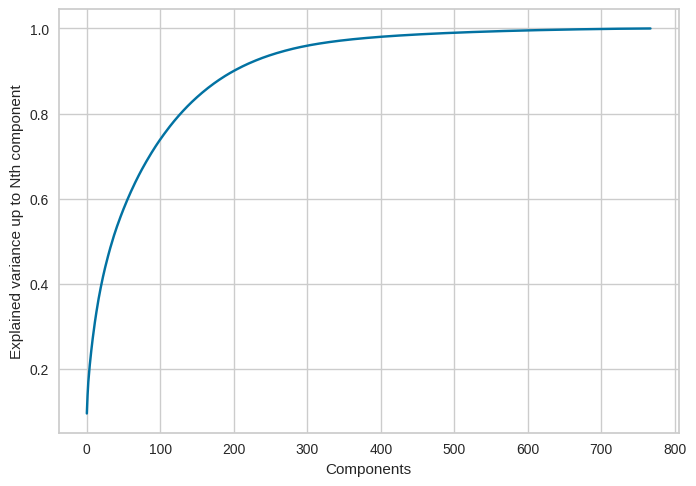

In [56]:
pca = PCA(n_components=768)
pca_bert = pca.fit_transform(embedding)
pca_bert.shape
pca.explained_variance_ratio_.shape #is the number of information/data that contribute into explaining the dataset (it finds the correlation between data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Explained variance up to Nth component')

In [58]:
pca = PCA(n_components=200)
pca_bert = pca.fit_transform(embedding)
pca_bert.shape

(10000, 200)

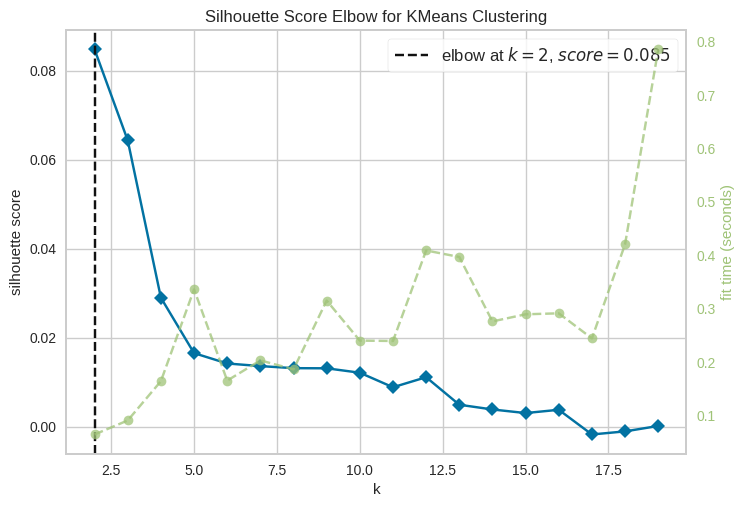

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [61]:
from yellowbrick.cluster import KElbowVisualizer


model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 20), metric='silhouette')

# EXERCISE: fit to data, as always ;)
visualizer.fit(X)
visualizer.show()
# This will take a while

In [62]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(pca_bert)

In [63]:
np.mean(cosine_sim_matrix)

0.0015316786

In [64]:
cosine_sim_matrix[0]

array([ 0.9999999 , -0.05032524, -0.10359264, ..., -0.18184608,
        0.18977053, -0.02710051], dtype=float32)

In [65]:
def calculate_ttr(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words) if len(words) > 0 else 0

In [66]:
calculate_ttr(' '.join(dataset_sampled['cleaned_text']))

0.06680475846604082

## Clustering

In [ ]:
# Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


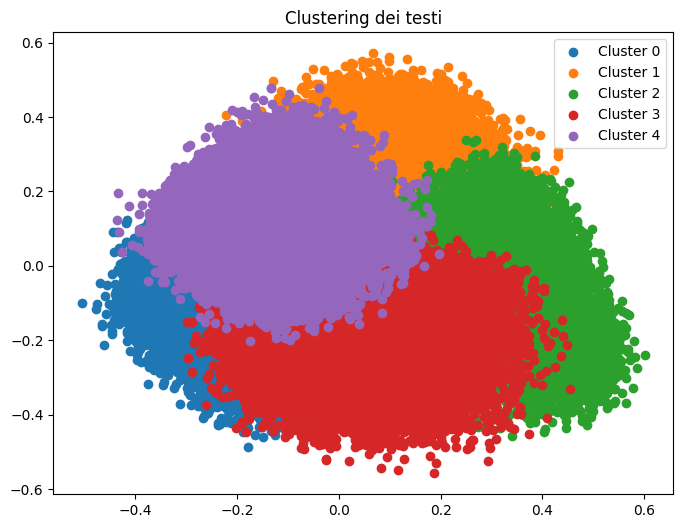

In [ ]:
# Visualizzazione (riduzione dimensionale con PCA)
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(embedding_2d[cluster_labels == i, 0], embedding_2d[cluster_labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title("Clustering dei testi")
plt.show()

In [ ]:
def score_clustering(true_labels, predicted_labels, embedding):
  d = {
      "Rand index": rand_score(true_labels, predicted_labels),
      "Adjusted Mutual Info": adjusted_mutual_info_score(true_labels, predicted_labels),
      "Homogeneity": homogeneity_score(true_labels, predicted_labels),
      "Completeness": completeness_score(true_labels, predicted_labels),
      "V measure": v_measure_score(true_labels, predicted_labels),
      "Fowlkes Mallows": fowlkes_mallows_score(true_labels, predicted_labels),
      "Silhoutte": silhouette_score(embedding, predicted_labels)
  }
  for k, v in d.items():
    print(f"{k:21s}: {v}")

In [ ]:
array = np.array(data["stars_x"])
ground_truth = array.astype(int)
type(ground_truth)

numpy.ndarray

In [ ]:
score_clustering(ground_truth, cluster_labels, embedding)

Rand index           : 0.6395525471254713
Adjusted Mutual Info : 0.07286153687216053
Homogeneity          : 0.07805384448550193
Completeness         : 0.0684040734835067
V measure            : 0.07291105851970782
Fowlkes Mallows      : 0.280026867464782
Silhoutte            : 0.016124187037348747


In [ ]:
n_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = agg_clustering.fit_predict(embedding)

MemoryError: unable to allocate array data.

In [ ]:
# Visualizzazione (riduzione dimensionale con PCA)
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(embedding_2d[cluster_labels == i, 0], embedding_2d[cluster_labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title("Clustering dei testi")
plt.show()

In [ ]:
score_clustering(ground_truth, cluster_labels, embedding)